In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [39]:
Target = 'Infected'
NonTarget = ['Fatal', 'Cured']

In [40]:
pjme = pd.read_csv('processed_data.csv', index_col=[0], parse_dates=[0])
pjme

,Infected,Fatal,Cured
index,,,
2020-03-21,9.0,0.0,0.0
2020-03-22,29.0,1.0,0.0
2020-03-23,22.0,0.0,0.0
2020-03-24,12.0,2.0,0.0
2020-03-25,29.0,1.0,0.0
2020-03-26,24.0,3.0,3.0
2020-03-27,18.0,3.0,3.0
2020-03-28,18.0,3.0,3.0
2020-03-29,18.0,2.0,0.0


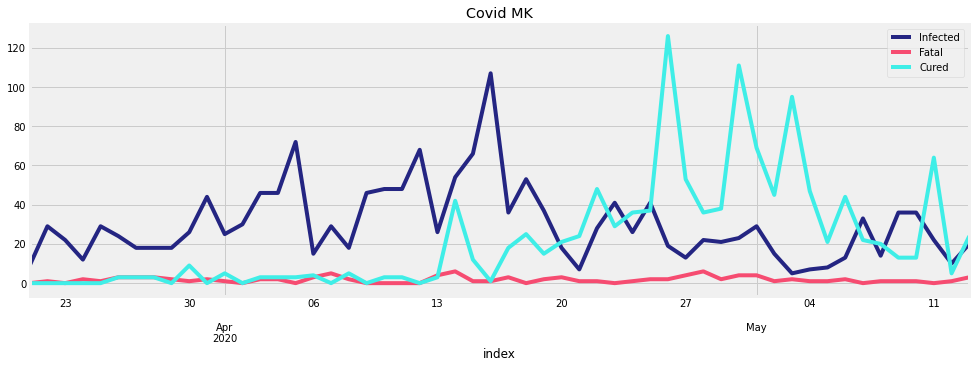

In [41]:
color_pal = ["#242582", "#f64c71", "#3feee7"]
_ = pjme.plot(style='-', figsize=(15,5), color=color_pal, title='Covid MK')

In [42]:
pjme = pjme.drop(NonTarget, axis = 1)

In [88]:
split_date = '2020-05-06'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

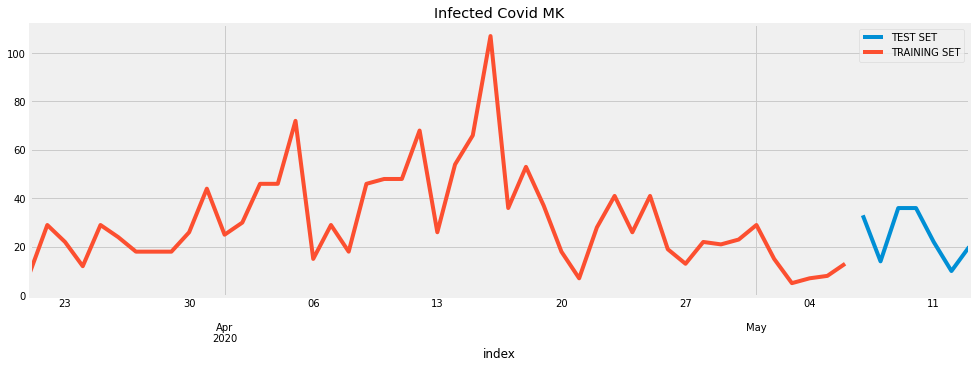

In [80]:
_ = pjme_test \
    .rename(columns={Target: 'TEST SET'}) \
    .join(pjme_train.rename(columns={Target: 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Infected Covid MK', style='-')

In [89]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df["index"]
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [90]:
pjme_train=pjme_train.reset_index()
pjme_test=pjme_test.reset_index()

In [99]:
pjme_train.head(1)

,index,Infected,date,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,2020-03-21,9.0,2020-03-21,5,1,3,81,21,12


In [92]:
X_train, y_train = create_features(pjme_train, label=Target)
X_test, y_test = create_features(pjme_test, label=Target)

In [104]:
X_train.describe()

,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,2.978723,1.765957,3.893617,104.000000,16.425532,15.574468
std,2.058803,0.427976,0.598333,13.711309,9.792954,1.997223
min,0.000000,1.000000,3.000000,81.000000,1.000000,12.000000
25%,1.000000,2.000000,4.000000,92.500000,6.500000,14.000000
50%,3.000000,2.000000,4.000000,104.000000,18.000000,16.000000
75%,5.000000,2.000000,4.000000,115.500000,25.000000,17.000000
max,6.000000,2.000000,5.000000,127.000000,31.000000,19.000000


In [105]:
reg = xgb.XGBRegressor()

In [106]:
reg.fit(X_train, y_train, verbose=True) # Change verbose to True if you want to see it train

KeyError: 'base_score'

KeyError: 'base_score'